# Non-Linear Classifiers

Today’s class will introduce modern neural network models, commonly known as deep learning models. We will learn the concept of computation graph, a general way of describing complex functions as composition of simpler functions. We will also learn about Backpropagation, a generic solution for gradient-descent based optimization in computation graphs.

<b> Exercise 3.1 </b>
<br>
To ease-up the upcoming implementation exercise, examine and comment the following implementation of a log-linear model and its gradient update rule. Start by loading Amazon sentiment corpus used in day 1

In [1]:
import numpy as np
import lxmls.readers.sentiment_reader as srs 
from lxmls.deep_learning.utils import AmazonData
corpus=srs.SentimentCorpus("books")
data = AmazonData(corpus=corpus)

In [2]:
print corpus.train_X

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
print corpus.train_y

[[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]


In [4]:
print "Number of instances to test", len(corpus.train_y)
print "Number of instances that belong to class 1: ",(corpus.train_y==1).sum()
print "Number of instances that belong to class 0: ",(corpus.train_y==0).sum()

Number of instances to test 1600
Number of instances that belong to class 1:  800
Number of instances that belong to class 0:  800


> Compare the following numpy implementation of a log-linear model with the derivations seen in the previous sections. Introduce comments on the blocks marked with # relating them to the corresponding algorithm steps.

In [5]:
from lxmls.deep_learning.utils import Model, glorot_weight_init, index2onehot 
import numpy as np
from scipy.misc import logsumexp

class NumpyLogLinear(Model):
    def __init__(self, **config):
        # Initialize parameters
        weight_shape = (config['input_size'], config['num_classes'])
        # after Xavier Glorot et al
        self.weight = glorot_weight_init(weight_shape, 'softmax')
        self.bias = np.zeros((1, config['num_classes']))
        self.learning_rate = config['learning_rate']

    def log_forward(self, input=None):
        """Forward pass of the computation graph"""
        
        #weighted sums of the node input plus a bias.  Sum(w*x)+b
        z = np.dot(input, self.weight.T) + self.bias 
        
        # Softmax implemented in log domain
        log_tilde_z = z - logsumexp(z, axis=1)[:, None]
        
        return log_tilde_z
    
    def predict(self, input=None):
        """Prediction: most probable class index"""
        return np.argmax(np.exp(self.log_forward(input)), axis=1)

    def update(self, input=None, output=None): 
        """Stochastic Gradient Descent update"""
        
        #compute class probabilities
        class_probabilities = np.exp(self.log_forward(input))
        batch_size, num_classes = class_probabilities.shape
        
        #Error derivative  of the cost function
        I = index2onehot(output, num_classes)
        error = (class_probabilities - I) / batch_size
        
        #Gradient with respect to the weights 
        gradient_weight = np.zeros(self.weight.shape) 
        for l in range(batch_size):
            gradient_weight += np.outer(error[l, :], input[l, :])
            
        #Gradient with respect to the bias 
        gradient_bias = np.sum(error, axis=0, keepdims=True)
        
        #update our parameters estimates with gradient descent (W ← W − η∇WF; b ← b − η∇bF,)
        self.weight = self.weight - self.learning_rate * gradient_weight
        self.bias = self.bias - self.learning_rate * gradient_bias

> Instantiate model and data classes. Check the initial accuracy of the model. This should be close to 50% since we are on a binary prediction task and the model is not trained yet.

In [6]:
# Instantiate model
model = NumpyLogLinear(
    input_size=corpus.nr_features,
    num_classes=2,
    learning_rate=0.05
)
# Define number of epochs and batch size
num_epochs = 10
batch_size = 30
# Instantiate data iterators
train_batches = data.batches('train', batch_size=batch_size)
test_set = data.batches('test', batch_size=None)[0]
# Check initial accuracy
hat_y = model.predict(input=test_set['input'])
accuracy = 100*np.mean(hat_y == test_set['output']) 
print("Initial accuracy %2.2f %%" % accuracy)

Initial accuracy 54.25 %


/Users/RitaRamos/anaconda/envs/mypy26/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


> Train the model with simple batch stochastic gradient descent. Be sure to understand each of the steps involved, including the code running inside of the model class. We will be wokring on a more complex version of the model in the upcoming exercise.

In [7]:
# Epoch loop
for epoch in range(num_epochs):

    # Batch loop
    for batch in train_batches:
        model.update(input=batch['input'], output=batch['output'])

    # Prediction for this epoch
    hat_y = model.predict(input=test_set['input'])

    # Evaluation
    accuracy = 100*np.mean(hat_y == test_set['output'])
    print("Epoch %d: accuracy %2.2f %%" % (epoch+1, accuracy))

/Users/RitaRamos/anaconda/envs/mypy26/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


Epoch 1: accuracy 70.50 %
Epoch 2: accuracy 73.75 %
Epoch 3: accuracy 76.25 %
Epoch 4: accuracy 77.75 %
Epoch 5: accuracy 78.75 %
Epoch 6: accuracy 79.25 %
Epoch 7: accuracy 79.25 %
Epoch 8: accuracy 80.25 %
Epoch 9: accuracy 80.50 %
Epoch 10: accuracy 80.50 %


<b> Exercise 3.2  </b>
<br>Instantiate the feed-forward model class and optimization parameters. This models follows the architecture described in Algorithm 10.

In [8]:
# Model
geometry = [corpus.nr_features, 20, 2]
activation_functions = ['sigmoid', 'softmax']
# Optimization
learning_rate = 0.05
num_epochs = 10
batch_size = 30
# Instantiate model
from lxmls.deep_learning.numpy_models.mlp import NumpyMLP 

model = NumpyMLP(
    geometry=geometry,
    activation_functions=activation_functions,
    learning_rate=learning_rate
)

In [9]:
from lxmls.deep_learning.mlp import get_mlp_parameter_handlers, get_mlp_loss_range
# Get functions to get and set values of a particular weight of the model
get_parameter, set_parameter = get_mlp_parameter_handlers(layer_index=1,is_bias=False, row=0, column=0)
# Get batch of data
batch = data.batches('train', batch_size=batch_size)[0]
# Get loss and weight value
current_loss = model.cross_entropy_loss(batch['input'], batch['output'])
current_weight = get_parameter(model.parameters)
# Get range of values of the weight and loss around current parameters values
weight_range, loss_range = get_mlp_loss_range(model, get_parameter, set_parameter, batch)

> Once you have implemented at least the gradient of the last layer. You can start checking if the values match

In [10]:
gradients = model.backpropagation(batch['input'], batch['output'])
current_gradient = get_parameter(gradients)

> Now you can plot the values of the loss around a given parameters value versus the gradient. If you have implemented this correctly the gradient should be tangent to the loss at the current weight value, see Figure 3.5. Once you have completed the exercise, you should be able to plot also the gradients of the other layers. Take into account that the gradients for the first layer will only be non zero for the indices of words present in the batch. You can locate this using.

In [11]:
batch['input'][0].nonzero()

(array([   59,   111,   125,   258,   302,   361,   514,   737,   743,
          814,   825,   872,   922,   977,  1094,  1280,  1286,  1296,
         1314,  1348,  1604,  1731,  1830,  1947,  2057,  2120,  2173,
         2235,  2245,  2261,  2331,  2347,  2492,  2555,  2608,  2638,
         2755,  2882,  3069,  3091,  3157,  3291,  3322,  3342,  3558,
         3769,  4203,  4478,  4509,  4718,  5033,  5136,  5244,  5305,
         5444,  5557,  5909,  6115,  6152,  6268,  6303,  6431,  6702,
         6720,  6735,  6810,  6926,  6961,  6986,  7168,  7187,  7364,
         7414,  7584,  7803,  7882,  8007,  8055,  8258,  8330,  8421,
         8552,  8925,  9037,  9048,  9383,  9599,  9732,  9778,  9809,
         9967, 10063, 10134, 10327, 10420, 10578, 10652, 10714, 10846,
        10964, 11003, 11105, 11432, 11530, 11719, 11720, 11732, 11791,
        11817, 11902, 11922, 11970, 11999, 12054, 12064, 12073, 12090,
        12116, 12139, 12287, 12397, 12544, 12554, 12558, 12772, 13299,
      

> Copy the following code for plotting

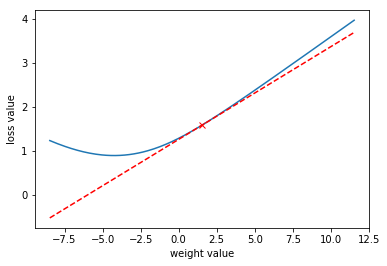

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot empirical
plt.plot(weight_range, loss_range)
plt.plot(current_weight, current_loss, 'xr')
plt.ylabel('loss value')
plt.xlabel('weight value')
# Plot real
h = plt.plot(
    weight_range,
    current_gradient*(weight_range - current_weight) + current_loss,'r--'
)

> After you have ensured that your Backpropagation algorithm is correct, you can train a model with the data we have.

In [13]:
# Get batch iterators for train and test
train_batches = data.batches('train', batch_size=batch_size)
test_set = data.batches('test', batch_size=None)[0]
# Epoch loop
for epoch in range(num_epochs):
# Batch loop
    for batch in train_batches:
        model.update(input=batch['input'], output=batch['output'])
        # Prediction for this epoch
    hat_y = model.predict(input=test_set['input'])
    # Evaluation
    accuracy = 100*np.mean(hat_y == test_set['output'])
    print("Epoch %d: accuracy %2.2f %%" % (epoch+1, accuracy))

Epoch 1: accuracy 64.25 %
Epoch 2: accuracy 68.75 %
Epoch 3: accuracy 73.75 %
Epoch 4: accuracy 74.50 %
Epoch 5: accuracy 76.50 %
Epoch 6: accuracy 77.25 %
Epoch 7: accuracy 79.75 %
Epoch 8: accuracy 80.00 %
Epoch 9: accuracy 81.00 %
Epoch 10: accuracy 81.00 %


# Deriving gradients and GPU code with Pytorch
<b> Exercise3.3 </b>
<br> 
In order to learn the differences between a numpy and a Pytorch implementation, explore the reimplementation of Ex. 3.1 in Pytorch. Compare the content of each of the functions, in particular the forward() and update methods(). The comments indicated as IMPORTANT will highlight common sources of errors.

In [21]:
import torch
from torch.autograd import Variable
class PytorchLogLinear(Model):
    def __init__(self, **config):
        # Initialize parameters
        weight_shape = (config['input_size'], config['num_classes'])
        
        # after Xavier Glorot et al
        self.weight = glorot_weight_init(weight_shape, 'softmax')
        self.bias = np.zeros((1, config['num_classes']))
        self.learning_rate = config['learning_rate']
        
        # IMPORTANT: Cast to pytorch format
        self.weight = Variable(torch.from_numpy(self.weight).float(), requires_grad=True)
        self.bias = Variable(torch.from_numpy(self.bias).float(), requires_grad=True)
        
        # Instantiate softmax and negative logkelihood in log domain
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)
        self.loss = torch.nn.NLLLoss()
        
    def _log_forward(self, input=None):
        """Forward pass of the computation graph in logarithm domain (pytorch)"""
        # IMPORTANT: Cast to pytorch format
        input = Variable(torch.from_numpy(input).float(), requires_grad=False) 
        
        # Linear transformation
        z = torch.matmul(input, torch.t(self.weight)) + self.bias 
        
        # Softmax implemented in log domain
        log_tilde_z = self.logsoftmax(z)
        
        # NOTE that this is a pytorch class!
        return log_tilde_z
    
    def predict(self, input=None):
        """Most probably class index"""
        log_forward = self._log_forward(input).data.numpy()
        return np.argmax(np.exp(log_forward), axis=1)
    
    def update(self, input=None, output=None): 
        """Stochastic Gradient Descent update"""    
        true_class = Variable(torch.from_numpy(output).long(), requires_grad=False)

        # Compute negative log-likelihood loss
        loss = torch.nn.NLLLoss()(self._log_forward(input), true_class)
        # Use autograd to compute the backward pass.
        loss.backward()

        # SGD update
        self.weight.data -= self.learning_rate * self.weight.grad.data
        self.bias.data -= self.learning_rate * self.bias.grad.data

        # Zero gradients
        self.weight.grad.data.zero_()
        self.bias.grad.data.zero_()

        return loss.data.numpy()

> Once you understand the model you can instantiate it and run it using the standard training loop we have used on previous exercises.

In [22]:
# Instantiate model
model = PytorchLogLinear(
    input_size=corpus.nr_features,
    num_classes=2,
    learning_rate=0.05
)

In [23]:
# Get batch iterators for train and test
train_batches = data.batches('train', batch_size=batch_size)
test_set = data.batches('test', batch_size=None)[0]

# Epoch loop
for epoch in range(num_epochs):
    # Batch loop
    for batch in train_batches:
        model.update(input=batch['input'], output=batch['output'])
        
    # Prediction for this epoch
    hat_y = model.predict(input=test_set['input'])

    # Evaluation
    accuracy = 100*np.mean(hat_y == test_set['output'])
    print("Epoch %d: accuracy %2.2f %%" % (epoch+1, accuracy))

Epoch 1: accuracy 70.50 %
Epoch 2: accuracy 73.75 %
Epoch 3: accuracy 76.25 %
Epoch 4: accuracy 77.75 %
Epoch 5: accuracy 78.75 %
Epoch 6: accuracy 79.25 %
Epoch 7: accuracy 79.25 %
Epoch 8: accuracy 80.25 %
Epoch 9: accuracy 80.50 %
Epoch 10: accuracy 80.50 %


<b> Exercise 3.4 </b>
<br> As the final exercise today implement the log forward() method in lxmls/deep learning/pytorch models/mlp.py. Use the previous exercise as reference. After you have completed this you can run both systems for comparison.